<a href="https://www.kaggle.com/code/sofiamatias/icecube-predictions?scriptVersionId=124809809" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Concepts and ideas

## How zenith and azimuth gives a direction
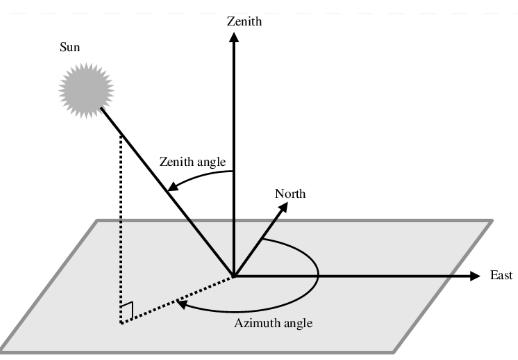

# Merge Data

In [1]:
!python --version

Python 3.7.12


In [2]:
def get_test_df_from_a_batch (test_batch_df, sensors_df, test_meta_df, batch_number):
    """
    Converts test_batch, test_meta and sensor_geometry into a 'test_df' dataframe containing features and targets
    It filters 'auxiliary' field to only 'False' values, due to challenge explanation:
    ' If True, the pulse was not fully digitized, is of lower quality, and was more likely to originate from noise.'
    It uses polars dataframes only.
    """
    test_batch_df = test_batch_df.filter(pl.col("auxiliary") == False)
    sensors_df = sensors_df.with_columns(pl.col('sensor_id').cast(pl.Int16, strict=False))
    test_df = test_batch_df.join (sensors_df, how='left', on = 'sensor_id')
    test_meta_batch_df = test_meta_df.filter(pl.col("batch_id") == batch_number)
    test_df = test_df.join (test_meta_batch_df, how='left', on = 'event_id')
    test_df = test_df.drop (columns=['batch_id', 'auxiliary'])
    test_df = test_df.drop (columns=['sensor_id', 'first_pulse_index', 'last_pulse_index'])
    #test_df = test_df.with_columns(xy = pl.col('x') * pl.col('y'))
    del test_meta_batch_df #memory
    del test_batch_df #memory
    print (f'\nTest dataframe:\n')
    print (test_df)
    return test_df

# Predictions function

In [3]:
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.features = self.df.to_numpy()
        self.scaler = StandardScaler()
        self.features = self.scaler.fit_transform(self.features)
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        features = self.features[idx] #maybe we need to apply the scaler here again
        return torch.tensor(features, dtype=torch.float32)

    
class CustomModel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(CustomModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 16)
        self.fc4 = torch.nn.Linear(16, 8)
        self.fc5 = torch.nn.Linear(8, output_size)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = torch.nn.functional.relu(self.fc4(x))
        x = self.fc5(x)
        return x

    
def predictions (test_dataset, batch_size, device, model_path):
    """
    Predicts zenith and azimuth.
    Parameters:
    x_test - test set features
    Output:
    az_preds, ze_preds
    """   

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    model = CustomModel(input_size=test_dataset.features.shape[1], output_size=2)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.to(device)

    predictions = []
    with torch.no_grad():
        for i, inputs in enumerate(test_loader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())

    return np.array(predictions)

# Model train

## Imports

In [4]:
#%%time
#!pip install /kaggle/input/hummingbird-ml-package/joblib-1.2.0-py3-none-any.whl
#!pip install /kaggle/input/hummingbird-ml-package/onnxconverter_common-1.13.0-py2.py3-none-any.whl
#!pip install /kaggle/input/hummingbird-ml-package/hummingbird_ml-0.4.4-py2.py3-none-any.whl
#print ('Finished installing hurmingbird.')

In [5]:
%%time
import polars as pl
import numpy as np
import pandas as pd
import os, gc

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

print ('\nFinished loading imports.\n')

if torch.cuda.is_available():
    import cudf
    device = 'cuda'
else:
    device = 'cpu'
    
print (f"Device for predictions is {device}.\n")

scores_df = pd.DataFrame([]) 
input_path = '/kaggle/input/'
work_path = '/kaggle/working/'
scores_path = f'{work_path}scores.csv'
saved_model_path = ''


Finished loading imports.

Device for predictions is cuda.

CPU times: user 1.27 s, sys: 267 ms, total: 1.54 s
Wall time: 3.4 s


## Load data

In [6]:
%%time
print ('Loading files...')
for dirname, _, filenames in os.walk(input_path):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        if 'model.pt' in filepath:
            saved_model_path = filepath
            print ("'model.pt' file path found and loaded.")
        elif 'score' in filepath:
            scores_df = pl.read_csv (filepath).to_pandas()
            print ("'scores' file loaded.")
        elif 'sensor' in filepath:
            sensors_df = pl.read_csv (filepath).lazy()
            print ("'sensor_geometry' file loaded.")
        elif 'test_meta' in filepath:
            test_meta_filepath = filepath
            print ("'test_meta' file path found and loaded.")

Loading files...
'scores' file loaded.
'model.pt' file path found and loaded.
'test_meta' file path found and loaded.
'sensor_geometry' file loaded.
CPU times: user 13.3 ms, sys: 4.38 ms, total: 17.7 ms
Wall time: 228 ms


In [7]:
%%time
# 9mins per batch if I feed the entire batch all at once. RAM runs out after a few batches.
print ('Starting predictions...\n')

submission_df = pl.DataFrame([]).lazy()
counts = 1
for dirname, _, filenames in os.walk(input_path):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        if ('batch' in filepath) and ('test' in dirname):
            test_meta_df = pl.read_parquet (test_meta_filepath).lazy()
            print ("'test_meta' file loaded.")
            test_batch_df = pl.read_parquet (filepath).lazy()
            print (f"\nLoading 'test_batch' file.\n")
            print (test_batch_df.collect())
            batch_number = int (filename.split('_')[1].split('.')[0])
            print (f"'test_batch_{batch_number}' file loaded.\n")
            print (f"\n\nPredicting values for batch id {batch_number} - batch {counts}\n\n")
            test_df = get_test_df_from_a_batch (test_batch_df.collect(), 
                                                 sensors_df.collect(), 
                                                 test_meta_df.collect(), 
                                                 batch_number)
            del test_batch_df #memory
            del test_meta_df #memory
            test_dataset = CustomDataset(test_df)
            if len(saved_model_path) == 0:
                print ('\nNo model to make predictions. Aborting.\n')
                break
            preds = predictions (test_dataset, batch_size = 128, device = device, model_path = saved_model_path)
            print ('Azimuth predictions:\n', preds[:,0])
            print ('Zenith predictions:\n', preds[:,1])
            if type(preds[0]) == int:
                print ('Predictions are not valid. Skipping these values and continuing with next batch.')
                break
            batch_results = {'event_id': test_df['event_id'], 'azimuth': preds[:,0], 'zenith': preds[:,1]}
            del test_df #memory
            batch_results_df = pl.DataFrame (batch_results).lazy()
            batch_results_df = batch_results_df.groupby('event_id').median()
            if submission_df.width == 0:
                submission_df = batch_results_df
            else:
                submission_df = pl.concat ([submission_df, batch_results_df])
            del batch_results_df
            gc.collect()
            counts += 1 
            if counts == 6:
                break

Starting predictions...

'test_meta' file loaded.

Loading 'test_batch' file.

shape: (378, 5)
┌───────────┬───────┬────────┬───────────┬──────────┐
│ sensor_id ┆ time  ┆ charge ┆ auxiliary ┆ event_id │
│ ---       ┆ ---   ┆ ---    ┆ ---       ┆ ---      │
│ i16       ┆ i64   ┆ f64    ┆ bool      ┆ i64      │
╞═══════════╪═══════╪════════╪═══════════╪══════════╡
│ 4066      ┆ 6170  ┆ 1.275  ┆ true      ┆ 2092     │
│ 3512      ┆ 6374  ┆ 0.975  ┆ true      ┆ 2092     │
│ 897       ┆ 6378  ┆ 1.475  ┆ true      ┆ 2092     │
│ 2060      ┆ 6590  ┆ 0.925  ┆ true      ┆ 2092     │
│ …         ┆ …     ┆ …      ┆ …         ┆ …        │
│ 2190      ┆ 14112 ┆ 1.075  ┆ true      ┆ 9482     │
│ 2057      ┆ 14713 ┆ 0.975  ┆ true      ┆ 9482     │
│ 4486      ┆ 14765 ┆ 1.425  ┆ true      ┆ 9482     │
│ 4159      ┆ 14929 ┆ 1.025  ┆ true      ┆ 9482     │
└───────────┴───────┴────────┴───────────┴──────────┘
'test_batch_661' file loaded.



Predicting values for batch id 661 - batch 1



Test dataframe

# Submissions

In [8]:
if type(submission_df) == pl.lazyframe.frame.LazyFrame:
    df_aux = submission_df.collect()
else:
    df_aux = submission_df
submission_df = df_aux.with_columns(pl.when(pl.col("azimuth") > 2*np.pi).then(2*3.141).otherwise(pl.col("azimuth")).alias('azimuth'),
                                    pl.when(pl.col("zenith") > np.pi).then(3.141).otherwise(pl.col("zenith")).alias('zenith'))
submission_df.write_csv (f'{work_path}submission.csv')
print(submission_df)

shape: (3, 3)
┌──────────┬──────────┬──────────┐
│ event_id ┆ azimuth  ┆ zenith   │
│ ---      ┆ ---      ┆ ---      │
│ i64      ┆ f32      ┆ f32      │
╞══════════╪══════════╪══════════╡
│ 2092     ┆ 1.923125 ┆ 1.056348 │
│ 9482     ┆ 6.282    ┆ 3.141    │
│ 7344     ┆ 0.427357 ┆ 0.80375  │
└──────────┴──────────┴──────────┘
